# Sampling CoCo image dataset to train and use DPM on

In [494]:
import json
import random
from pycocotools.coco import COCO
import requests
import os
import shutil
from tqdm import tqdm

from xml.etree.ElementTree import Element, SubElement, ElementTree, tostring 
from xml.dom.minidom import parseString 

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

from collections import defaultdict

We clear the folders beforehand

In [2]:
def clear_folder(folder_path):
    """
    Clears all files and subdirectories in the specified folder.

    Args:
        folder_path (str): Path to the folder to clear.
    """
    if os.path.exists(folder_path):
        # Remove all contents of the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Remove file or symbolic link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Remove directory
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        # If folder doesn't exist, create it
        os.makedirs(folder_path)


Helper function to make PASCAL VOC-style XML annotations.

In [3]:
# Function to create Pascal-style XML annotations
def create_pascal_xml(img_info, annotations, output_annotation_dir, categories):
    """
    Generates a Pascal VOC-style XML file for a given image and its annotations.

    Args:
    - img_info (dict): Image metadata from COCO.
    - annotations (list): List of annotations for the image.
    - output_annotation_dir (str): Directory to save the XML file.
    - categories (list): List of category names to include in the annotations.
    """
    from xml.etree.ElementTree import Element, SubElement, tostring
    from xml.dom.minidom import parseString
    import os

    xml_root = Element('annotation')
    folder = SubElement(xml_root, 'folder')
    folder.text = 'VOC2007'

    filename = SubElement(xml_root, 'filename')
    filename.text = img_info['file_name']

    # default source
    source = SubElement(xml_root, 'source')
    database = SubElement(source, 'database')
    database.text = 'COCO Database'

    image = SubElement(source, 'image')
    image.text = 'flickr'

    annotation_tag = SubElement(source, 'annotation')
    annotation_tag.text = 'PASCAL VOC2007'

    flicker_id = SubElement(source, 'flickerid')
    flicker_id.text = '341012865'

    # default owner
    owner = SubElement(xml_root, 'owner')
    flicker_id = SubElement(owner, 'flickerid')
    flicker_id.text = 'Default owner'
    owner_name = SubElement(owner, 'name')
    owner_name.text = 'Default ownername'

    size = SubElement(xml_root, 'size')
    SubElement(size, 'width').text = str(img_info['width'])
    SubElement(size, 'height').text = str(img_info['height'])
    SubElement(size, 'depth').text = '3'  # Assuming RGB images

    segmented = SubElement(xml_root, 'segmented')
    segmented.text = '0'

    for ann in annotations:
        # Include only objects in the specified categories
        cat_id = ann['category_id']
        if cat_id not in id_categories.keys():
            continue

        obj = SubElement(xml_root, 'object')
        name = SubElement(obj, 'name')
        cat_name = id_categories[cat_id]
        name.text = cat_name  # Category name from COCO annotation

        # Default difficulty 0
        difficult = SubElement(obj, 'difficult')
        difficult.text = '0'
        
        # Default pose and truncated values
        pose = SubElement(obj, 'pose')
        pose.text = 'Unspecified'

        truncated = SubElement(obj, 'truncated')
        bbox = ann['bbox']  # COCO format: [xmin, ymin, width, height]
        x_min = bbox[0]
        y_min = bbox[1]
        x_max = bbox[0] + bbox[2]
        y_max = bbox[1] + bbox[3]
        is_truncated = (
            x_min < 0 or y_min < 0 or x_max > img_info['width'] or y_max > img_info['height']
        )
        truncated.text = '1' if is_truncated else '0'

        # Bounding box
        bndbox = SubElement(obj, 'bndbox')
        SubElement(bndbox, 'xmin').text = str(max(0, int(x_min)))  # Clip to image boundaries
        SubElement(bndbox, 'ymin').text = str(max(0, int(y_min)))
        SubElement(bndbox, 'xmax').text = str(min(img_info['width'], int(x_max)))
        SubElement(bndbox, 'ymax').text = str(min(img_info['height'], int(y_max)))

    # If no relevant annotations, skip saving the XML
    if not any(cat_name in categories for ann in annotations):
        print(f"Skipping XML generation for {img_info['file_name']} - no relevant annotations.")
        return

    # Pretty format 
    asstring = tostring(xml_root, 'utf-8')
    parsed_xml = parseString(asstring)
    pretty_xml = parsed_xml.toprettyxml(indent="\t")

    # Remove the XML declaration manually
    pretty_xml = '\n'.join(pretty_xml.splitlines()[1:])

    # Save XML
    output_file = os.path.join(output_annotation_dir, f"{os.path.splitext(img_info['file_name'])[0]}.xml")
    with open(output_file, 'w') as f:
        f.write(pretty_xml)


In [4]:
# downloading 2000 images of training data for category person
# Paths
keypoints_annotation_file = 'annotations/person_keypoints_train2017.json'  # Update with your COCO annotation file path
annotation_file = 'annotations/instances_train2017.json'  # Update with your COCO annotation file path
output_dir = '/Users/junitasirait/Documents/princetoncourses/cos429/project/COCO_VOCdevkit/VOC2007'  # Folder to save downloaded images
annotations_dir = os.path.join(output_dir, 'Annotations')
sets_dir = os.path.join(output_dir, 'ImageSets', 'Main')
images_dir = os.path.join(output_dir, 'JPEGImages')
# os.makedirs(output_dir, exist_ok=True)

# Number of images to sample
num_images = 10

In [5]:
# Load COCO annotations
coco = COCO(annotation_file)

loading annotations into memory...
Done (t=12.26s)
creating index...
index created!


In [566]:
categories = [
    'airplane', 
    'bicycle', 
    'bird', 
    'boat', 
    'bottle', 
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'dining table',
    'dog', 
    'horse', 
    'motorcycle', 
    'person', 
    'potted plant',
    'sheep',
    'couch',
    'train', 
    'TV',
    # parts
    'head',
    'torso', 
    'arm',
]

In [567]:
category_ids = {cat['name']: cat['id'] for cat in coco.loadCats(coco.getCatIds()) if cat['name'] in categories}
# parts
category_ids['head'] = 100
category_ids['torso'] = 101
category_ids['arm'] = 102
id_categories = {v:k for (k,v) in category_ids.items()}
# category_ids
category_ids

{'person': 1, 'head': 100, 'torso': 101, 'arm': 102}

In [80]:
# Sampling for non-person categories
num_images_per_category = 300
person_instance_target = 5000

## Clean all

In [81]:
# To freshly download (erase existing data) 
clear_folder(annotations_dir)
clear_folder(sets_dir)
clear_folder(images_dir)

## Sampling

Sampling from CoCo dataset to form person and non-person data of similar size as Pascal. 

In [568]:
# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

all_images = set()
# Track globally selected image IDs to avoid duplicates
globally_selected_image_ids = set()
random.seed(429)

# Prepare data structures
# train_txt_path = os.path.join(sets_dir, "train.txt")
# category_txt_files = {category: open(os.path.join(sets_dir, f"{category}_train.txt"), "w") for category in categories}
positive_samples = {category: set() for category in categories}
annotations_by_image = {}

# Prepare split-specific data structures
splits = {
    "train": {"image_ids": set(), "annotations": {}, "images": set()},
    "val": {"image_ids": set(), "annotations": {}, "images": set()},
    "test": {"image_ids": set(), "annotations": {}, "images": set()},
    "trainval": {"image_ids": set(), "annotations": {}, "images": set()}
}

# Initialize global variables
all_images = set()  # To track downloaded images
globally_selected_image_ids = set()  # Track globally selected image IDs
random.seed(429)  # Ensure reproducibility

# Ensure image directory exists
os.makedirs(images_dir, exist_ok=True)

# Process each category
for category, category_id in tqdm(category_ids.items(), desc="Processing categories"):
    print(f"Processing category: {category}")
    
    # Handle 'person' category separately
    if category == 'person':
        instance_target = person_instance_target
        instance_count = 0
        selected_image_ids = []
        image_ids = coco.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)

        # Collect images until the instance target is reached
        for img_id in image_ids:
            print(f"Person count now: {instance_count}")
            if img_id in globally_selected_image_ids:
                continue
            ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=[category_id])
            person_count = len(ann_ids)
            if instance_count + person_count <= instance_target:
                selected_image_ids.append(img_id)
                globally_selected_image_ids.add(img_id)
                instance_count += person_count
            else:
                break
        print(f"Selected {len(selected_image_ids)} images to meet {instance_count} 'person' instances.")
    else:
        # Default behavior for other categories
        image_ids = coco.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)
        selected_image_ids = []
        for img_id in image_ids:
            if img_id in globally_selected_image_ids:
                continue
            selected_image_ids.append(img_id)
            globally_selected_image_ids.add(img_id)
            if len(selected_image_ids) >= num_images_per_category:
                break
    print(f"Selected {len(selected_image_ids)} unique images for category {category}.")

    # Split selected images into train, val, and test
    random.shuffle(selected_image_ids)
    num_images = len(selected_image_ids)
    train_end = int(num_images * train_ratio)
    val_end = train_end + int(num_images * val_ratio)
    print(f"num_immages: {num_images}, train_end: {train_end}, val_end: {val_end}")

    splits["train"]["image_ids"].update(selected_image_ids[:train_end])
    splits["val"]["image_ids"].update(selected_image_ids[train_end:val_end])
    splits["test"]["image_ids"].update(selected_image_ids[val_end:])

    # Collect annotations and positive samples
    for split in ["train", "val", "test"]:
        for img_id in splits[split]["image_ids"]:
            annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
            splits[split]["annotations"][img_id] = annotations
            splits[split]["images"].add(
                os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
            )
            # Update positive samples
            for ann in annotations:
                cat_id = ann['category_id']
                if cat_id in id_categories.keys():
                    positive_samples[id_categories[cat_id]].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )

# Create trainval split (combine train and val)
splits["trainval"]["image_ids"] = splits["train"]["image_ids"].union(splits["val"]["image_ids"])
splits["trainval"]["annotations"] = {**splits["train"]["annotations"], **splits["val"]["annotations"]}
splits["trainval"]["images"] = splits["train"]["images"].union(splits["val"]["images"])

# Download images and create XML annotations for each split
for split, data in splits.items():
    for img_id, annotations in tqdm(data["annotations"].items(), desc=f"Processing {split} images"):
        img_info = coco.loadImgs(img_id)[0]
        img_filename = os.path.splitext(img_info['file_name'])[0]
        img_filepath = os.path.join(images_dir, img_info['file_name'])

        # Download the image if not already downloaded
        if img_filename not in all_images:
            if not os.path.exists(img_filepath):
                try:
                    response = requests.get(img_info['coco_url'], stream=True, timeout=10)
                    response.raise_for_status()
                    with open(img_filepath, 'wb') as f:
                        for chunk in response.iter_content(1024):
                            f.write(chunk)
                except requests.exceptions.RequestException as e:
                    print(f"Failed to download {img_info['file_name']}: {e}")
                    continue  # Skip this image on failure

            all_images.add(img_filename)

        # Generate XML annotation
        create_pascal_xml(img_info, annotations, annotations_dir, categories)

# Write ImageSets files for each split
for split, data in splits.items():
    txt_path = os.path.join(sets_dir, f"{split}.txt")
    with open(txt_path, "w") as file:
        for img_filename in sorted(data["images"]):
            file.write(f"{img_filename}\n")

    # Write category-specific files
    for category in categories:
        category_txt_path = os.path.join(sets_dir, f"{category}_{split}.txt")
        with open(category_txt_path, "w") as category_file:
            for img_filename in sorted(data["images"]):
                label = "1" if img_filename in positive_samples[category] else "-1"
                category_file.write(f"{img_filename} {label}\n")

print(f"ImageSets for train, val, test, and trainval created at {sets_dir}.")


Processing categories:   0%|                              | 0/4 [00:00<?, ?it/s]

Processing category: person


NameError: name 'person_instance_target' is not defined

## Sampling for parts

### Explorations

In [6]:
coco = COCO(keypoints_annotation_file)

loading annotations into memory...
Done (t=7.45s)
creating index...
index created!


idcs_to_show: [51, 52, 53]
image id: 579267


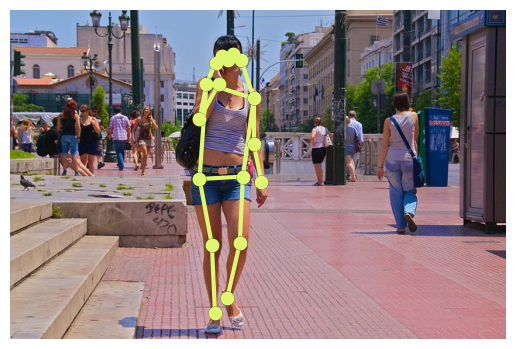

In [555]:
# random.seed(429)
person_sample = random.sample(sorted(coco.getImgIds(catIds=[1])), 1)[0]
person_sample = 579267  # 168215, 26817, 178557, 345100, 115146, 555537, 431555, 245415
person_sample

# Let's select one image to visualize
img_id = person_sample
annotation_ids = coco.getAnnIds(imgIds=img_id, catIds=[1])
annotation_id = annotation_ids[0]
len(annotation_ids), annotation_ids[0]

loaded_annotations = coco.loadAnns(ids=annotation_ids)
len(loaded_annotations)

# download image 
image_info = coco.loadImgs(img_id)[0]
response = requests.get(image_info['coco_url'])
image = Image.open(BytesIO(response.content))

# let's visualize the keypoints one by one 
kp_vis = 17
idcs_to_show = [kp_vis*3, kp_vis*3+1, kp_vis*3+2]
print(f"idcs_to_show: {idcs_to_show}")
kp_mask = [1 if i in idcs_to_show else 0 for i in range(51)]
original_keypoints = loaded_annotations[0]['keypoints']
kps = [original_keypoints[i] if kp_mask[i] else 0 for i in range(51)]

original_annotation = {
    # 'keypoints': kps, 
    'keypoints': original_keypoints, 
    'category_id': 1,
}

print(f"image id: {person_sample}")
plt.imshow(image)
plt.axis('off')
coco.showAnns([original_annotation], draw_bbox=False)

# according to 206431 need to also consider shoulders most likely
# silly examples: 369872, 178166, 567671

In [232]:
loaded_annotations[0].keys()

dict_keys(['segmentation', 'num_keypoints', 'area', 'iscrowd', 'keypoints', 'image_id', 'bbox', 'category_id', 'id'])

In [82]:
# looking at length of keypoints 
[len(a['keypoints']) for a in loaded_annotations]

# so we know that this length is always 51 -- if a keypoint does not exist then it is represented as 0,0,0

[51, 51]

In [309]:
# Keypoints
kpd = {
    0: 'nose', 
    1: 'left_eye', 
    2: 'right_eye', 
    3: 'left_ear', 
    4: 'right_ear', 
    5: 'left_shoulder', 
    6: 'right_shoulder', 
    7: 'left_elbow', 
    8: 'right_elbow', 
    9: 'left_wrist', 
    10: 'right_wrist', 
    11: 'left_hip', 
    12: 'right_hip', 
    13: 'left_knee', 
    14: 'right_knee', 
    15: 'left_ankle', 
    16: 'right_ankle', 
}


In [312]:
# Part 1: Head. Keypoints: 0, 5, 6.
# Part 2: Torso. Keypoints: 5, 6, 11, 12. 
# Part 3: Lower arm. Keypoints: 7/8, 9/10, with pad half the length (all sides). 
# Part 4: Lower legs. Keypoints: 13/14, 15/16, with pad half the length (all sides).

# visibility 2 -- visible and labelled

### Head

In [629]:
def is_head_present(person_annotation):
    # given an annotation from 'person' category, we check if head part is present 
    original_keypoints = person_annotation['keypoints']
    nose_visible = original_keypoints[2]
    leftshoulder_visible = original_keypoints[17]
    rightshoulder_visible = original_keypoints[20]
    return nose_visible==2 and leftshoulder_visible==2 and rightshoulder_visible==2

def is_leftarm_present(person_annotation):
    original_keypoints = person_annotation['keypoints']
    leftelbow_visible = original_keypoints[23]
    leftwrist_visible = original_keypoints[29]
    return leftshoulder_visible==2 and rightshoulder_visible==2

def is_rightarm_present(person_annotation):
    original_keypoints = person_annotation['keypoints']
    rightelbow_visible = original_keypoints[26]
    rightwrist_visible = original_keypoints[22]
    return rightelbow_visible==2 and rightwrist_visible==2

In [630]:
def get_head_bbox(person_annotation):
    original_keypoints = person_annotation['keypoints']
    nose_x, nose_y, nose_visible = original_keypoints[0:3]
    leftshoulder_x, leftshoulder_y, leftshoulder_visible = original_keypoints[15:18]
    rightshoulder_x, rightshoulder_y, rightshoulder_visible = original_keypoints[18:21]
        
    xmin = min(nose_x, leftshoulder_x, rightshoulder_x)  #, leftear_x, rightear_x)
    print(f"xmin: {xmin}")
    print(f"nose: {[nose_x, nose_y]}")
    print(f"rightshoulder: {[rightshoulder_x, rightshoulder_y]}")
    ymax = max(nose_y, leftshoulder_y, rightshoulder_y)  #, leftear_y, rightear_y) 
    ymin = min(leftshoulder_y, rightshoulder_y, nose_y) - abs(nose_y - ymax)
    xmax = max(nose_x, leftshoulder_x, rightshoulder_x)  #, leftear_x, rightear_x)
    width = abs(xmax - xmin)
    height = abs(ymax - ymin)

    return [xmin, ymin, width, height]


def get_leftarm_bbox(person_annotation):
    original_keypoints = person_annotation['keypoints']
    leftelbow_x, leftelbow_y, leftelbow_visible = original_keypoints[21:24]
    leftwrist_x, leftwrist_y, leftwrist_visible = original_keypoints[27:30]

    xpad = abs(leftelbow_x - leftwrist_x)//2
    ypad = abs(leftelbow_y - leftwrist_y)//2
    pad = max(xpad, ypad)
    xmin = min(leftelbow_x, leftwrist_x) - pad  #, leftear_x, rightear_x)
    ymin = min(leftelbow_y, leftwrist_y) - pad
    
    width = abs(leftelbow_x - leftwrist_x) + 2*pad
    height = abs(leftelbow_y - leftwrist_y) + 2*pad
    return [xmin, ymin, width, height]

def get_rightarm_bbox(person_annotation):
    original_keypoints = person_annotation['keypoints']
    rightelbow_x, rightelbow_y, rightelbow_visible = original_keypoints[24:27]
    rightwrist_x, rightwrist_y, rightwrist_visible = original_keypoints[30:33]

    xpad = abs(rightelbow_x - rightwrist_x)//2
    ypad = abs(rightelbow_y - rightwrist_y)//2
    pad = max(xpad, ypad)
    xmin = min(rightelbow_x, rightwrist_x) - pad  #, leftear_x, rightear_x)
    ymin = min(rightelbow_y, rightwrist_y) - pad
    
    width = abs(rightelbow_x - rightwrist_x) + 2*pad
    height = abs(rightelbow_y - rightwrist_y) + 2*pad
    return [xmin, ymin, width, height]

In [556]:
head_output_dir = 'coco_output/head/VOC2007'  # Folder to save downloaded images
head_annotations_dir = os.path.join(head_output_dir, 'Annotations')
head_sets_dir = os.path.join(head_output_dir, 'ImageSets', 'Main')
head_images_dir = os.path.join(head_output_dir, 'JPEGImages')

xmin: 24
head present? True
leftarm present? True
original bbox: [1.08, 47.46, 319.28, 426.07]
head bbox: [24, 282, 264, 207]
image id: 561842


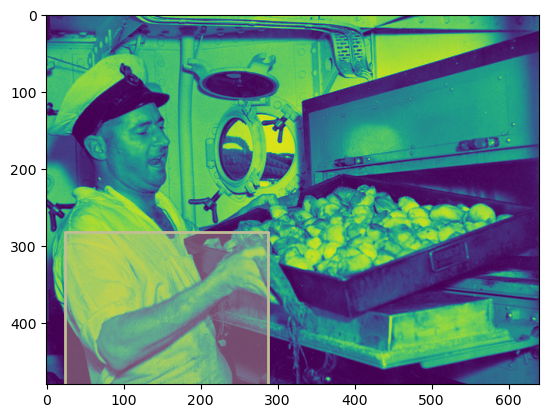

In [632]:
# random.seed(429)
person_sample = random.sample(sorted(coco.getImgIds(catIds=[1])), 1)[0]
person_sample = 561842  # 168215, 26817, 178557, 345100, 115146, 555537, 431555, 245415
person_sample

# Let's select one image to visualize
img_id = person_sample
annotation_ids = coco.getAnnIds(imgIds=img_id, catIds=[1])
annotation_id = annotation_ids[0]
len(annotation_ids), annotation_ids[0]

loaded_annotations = coco.loadAnns(ids=annotation_ids)
len(loaded_annotations)

# download image 
image_info = coco.loadImgs(img_id)[0]
response = requests.get(image_info['coco_url'])
image = Image.open(BytesIO(response.content))

xmin, ymin, width, height = get_rightarm_bbox(loaded_annotations[0])
# original_keypoints = loaded_annotations[0]['keypoints']
# # nose_x, nose_y, nose_visible = original_keypoints[0:3]
# # leftshoulder_x, leftshoulder_y, leftshoulder_visible = original_keypoints[15:18]
# # rightshoulder_x, rightshoulder_y, rightshoulder_visible = original_keypoints[18:21]
# leftelbow_x, leftelbow_y, leftelbow_visible = original_keypoints[21:24]
# leftwrist_x, leftwrist_y, leftwrist_visible = original_keypoints[27:30]
    
# # xmin = min(leftelbow_x, leftwrist_x)  #, leftear_x, rightear_x)
# # ymax = max(leftelbow_y, leftwrist_y)  #, leftear_y, rightear_y) 
# # ymin = min(leftelbow_y, leftwrist_y) 
# # xmax = max(leftelbow_x, leftwrist_x)  #, leftear_x, rightear_x)
# xpad = abs(leftelbow_x - leftwrist_x)//2
# ypad = abs(leftelbow_y - leftwrist_y)//2
# pad = max(xpad, ypad)
# xmin = min(leftelbow_x, leftwrist_x) - pad  #, leftear_x, rightear_x)
# ymin = min(leftelbow_y, leftwrist_y) - pad

# width = abs(leftelbow_x - leftwrist_x) + 2*pad
# height = abs(leftelbow_y - leftwrist_y) + 2*pad

print(f"xmin: {xmin}")
print(f"head present? {is_head_present(loaded_annotations[0])}")
print(f"leftarm present? {is_leftarm_present(loaded_annotations[0])}")
print(f"original bbox: {loaded_annotations[0]['bbox']}")
print(f"head bbox: {[xmin, ymin, width, height]}")


original_annotation = {
    'keypoints': kps, 
    # 'keypoints': original_keypoints, 
    # 'bbox': loaded_annotations[0]['bbox'],
    'bbox': [xmin, ymin, width, height], 
    # 'bbox': [232.6, 34.29, 50, 200], 
    'category_id': 1, 
}

print(f"image id: {person_sample}")
plt.imshow(image)
# plt.axis('off')
coco.showAnns([original_annotation], draw_bbox=True)

# according to 206431 need to also consider shoulders most likely
# silly examples: 369872, 178166, 567671, 471771, 548882
# sideways: 455328, 189376, 503021

In [569]:
# Function to create Pascal-style XML annotations
def create_head_xml(img_info, annotations, output_annotation_dir, categories):
    """
    Generates a Pascal VOC-style XML file for a given image and its annotations.

    Args:
    - img_info (dict): Image metadata from COCO.
    - annotations (list): List of annotations for the image.
    - output_annotation_dir (str): Directory to save the XML file.
    - categories (list): List of category names to include in the annotations.
    """

    xml_root = Element('annotation')
    folder = SubElement(xml_root, 'folder')
    folder.text = 'VOC2007'

    filename = SubElement(xml_root, 'filename')
    filename.text = img_info['file_name']

    # default source
    source = SubElement(xml_root, 'source')
    database = SubElement(source, 'database')
    database.text = 'COCO Database'

    image = SubElement(source, 'image')
    image.text = 'flickr'

    annotation_tag = SubElement(source, 'annotation')
    annotation_tag.text = 'PASCAL VOC2007'

    flicker_id = SubElement(source, 'flickerid')
    flicker_id.text = '341012865'

    # default owner
    owner = SubElement(xml_root, 'owner')
    flicker_id = SubElement(owner, 'flickerid')
    flicker_id.text = 'Default owner'
    owner_name = SubElement(owner, 'name')
    owner_name.text = 'Default ownername'

    size = SubElement(xml_root, 'size')
    SubElement(size, 'width').text = str(img_info['width'])
    SubElement(size, 'height').text = str(img_info['height'])
    SubElement(size, 'depth').text = '3'  # Assuming RGB images

    segmented = SubElement(xml_root, 'segmented')
    segmented.text = '0'

    for ann in annotations:
        # Include only objects in the specified categories
        cat_id = ann['category_id']
        if cat_id not in id_categories.keys():
            continue

        cat_name = id_categories[cat_id]

        # for parts, 
        # {'head': [[]], 'torso': [[]], 'upperarm': [[], []]}
        # for non person, 
        # {'car': [[]]}
        category_bbox = defaultdict(list)

        # Bounding box (bbox) depends on the parts 
        # the same annotation could be used for different parts 
        if cat_name == 'person':
            original_bbox = ann['bbox']
            # head 
            if is_head_present(ann):
                bbox = get_head_bbox(ann)
                category_bbox['head'].append(bbox)
        else:
            bbox = ann['bbox']  # COCO format: [xmin, ymin, width, height]
            category_bbox[cat_name].append(bbox)

        for final_category, bboxes in category_bbox.items():
            for bbox in bboxes:
                x_min = bbox[0]
                y_min = bbox[1]
                x_max = bbox[0] + bbox[2]
                y_max = bbox[1] + bbox[3]
        
                obj = SubElement(xml_root, 'object')
                name = SubElement(obj, 'name')
                name.text = final_category  # Category name from COCO annotation
        
                # Default difficulty 0
                difficult = SubElement(obj, 'difficult')
                difficult.text = '0'
                
                # Default pose and truncated values
                pose = SubElement(obj, 'pose')
                pose.text = 'Unspecified'
        
                truncated = SubElement(obj, 'truncated')
                is_truncated = (
                    x_min < 0 or y_min < 0 or x_max > img_info['width'] or y_max > img_info['height']
                )
                truncated.text = '1' if is_truncated else '0'
        
                # Bounding box
                bndbox = SubElement(obj, 'bndbox')
                SubElement(bndbox, 'xmin').text = str(max(0, int(x_min)))  # Clip to image boundaries
                SubElement(bndbox, 'ymin').text = str(max(0, int(y_min)))
                SubElement(bndbox, 'xmax').text = str(min(img_info['width'], int(x_max)))
                SubElement(bndbox, 'ymax').text = str(min(img_info['height'], int(y_max)))

    # If no relevant annotations, skip saving the XML
    if not any(cat_name in categories for ann in annotations):
        print(f"Skipping XML generation for {img_info['file_name']} - no relevant annotations.")
        return

    # Pretty format 
    asstring = tostring(xml_root, 'utf-8')
    parsed_xml = parseString(asstring)
    pretty_xml = parsed_xml.toprettyxml(indent="\t")

    # Remove the XML declaration manually
    pretty_xml = '\n'.join(pretty_xml.splitlines()[1:])

    # Save XML
    output_file = os.path.join(output_annotation_dir, f"{os.path.splitext(img_info['file_name'])[0]}.xml")
    with open(output_file, 'w') as f:
        f.write(pretty_xml)


In [570]:
head_instance_target = 50
arm_instance_target = 50

In [571]:
# To freshly download (erase existing data) 
clear_folder(head_annotations_dir)
clear_folder(head_sets_dir)
clear_folder(head_images_dir)

In [572]:
head_sets_dir

'coco_output/head/VOC2007/ImageSets/Main'

In [573]:
# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

all_images = set()
# Track globally selected image IDs to avoid duplicates
globally_selected_image_ids = set()
random.seed(429)

# Prepare data structures
# train_txt_path = os.path.join(sets_dir, "train.txt")
# category_txt_files = {category: open(os.path.join(sets_dir, f"{category}_train.txt"), "w") for category in categories}
positive_samples = defaultdict(set)
annotations_by_image = {}

# Prepare split-specific data structures
splits = {
    "train": {"image_ids": set(), "annotations": {}, "images": set()},
    "val": {"image_ids": set(), "annotations": {}, "images": set()},
    "test": {"image_ids": set(), "annotations": {}, "images": set()},
    "trainval": {"image_ids": set(), "annotations": {}, "images": set()}
}

# Ensure image directory exists
os.makedirs(images_dir, exist_ok=True)

# Process each category
for category, category_id in tqdm(category_ids.items(), desc="Processing categories"):
    print(f"Processing category: {category}")
    
    # Handle 'person' category separately
    if category == 'person':
        instance_target = head_instance_target
        instance_count = 0
        selected_image_ids = []
        image_ids = coco.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)

        # Collect images until the instance target is reached
        for img_id in image_ids:
            print(f"Person count now: {instance_count}")
            if img_id in globally_selected_image_ids:
                continue
            ann_ids = coco.getAnnIds(imgIds=[img_id], catIds=[category_id])
            # person_count = len(ann_ids)
            head_count = sum([is_head_present(ann) for ann in coco.loadAnns(ann_ids)])
            if instance_count + head_count <= instance_target:
                selected_image_ids.append(img_id)
                globally_selected_image_ids.add(img_id)
                instance_count += head_count
            else:
                break
        print(f"Selected {len(selected_image_ids)} images to meet {instance_count} 'head' instances.")
    else:
        # Default behavior for other categories
        image_ids = coco.getImgIds(catIds=[category_id])
        random.shuffle(image_ids)
        selected_image_ids = []
        for img_id in image_ids:
            if img_id in globally_selected_image_ids:
                continue
            selected_image_ids.append(img_id)
            globally_selected_image_ids.add(img_id)
            if len(selected_image_ids) >= num_images_per_category:
                break
    print(f"Selected {len(selected_image_ids)} unique images for category {category}.")

    # Split selected images into train, val, and test
    random.shuffle(selected_image_ids)
    num_images = len(selected_image_ids)
    train_end = int(num_images * train_ratio)
    val_end = train_end + int(num_images * val_ratio)
    print(f"num_immages: {num_images}, train_end: {train_end}, val_end: {val_end}")

    splits["train"]["image_ids"].update(selected_image_ids[:train_end])
    splits["val"]["image_ids"].update(selected_image_ids[train_end:val_end])
    splits["test"]["image_ids"].update(selected_image_ids[val_end:])

    # Collect annotations and positive samples
    for split in ["train", "val", "test"]:
        for img_id in splits[split]["image_ids"]:
            annotations = coco.loadAnns(coco.getAnnIds(imgIds=[img_id]))
            splits[split]["annotations"][img_id] = annotations
            splits[split]["images"].add(
                os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
            )
            # Update positive samples
            for ann in annotations:
                cat_id = ann['category_id']
                if cat_id in id_categories.keys():
                    positive_samples[id_categories[cat_id]].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )
                # check for head part
                if ann['category_id'] == 1 and is_head_present(ann):
                    positive_samples['head'].add(
                        os.path.splitext(coco.loadImgs(img_id)[0]['file_name'])[0]
                    )

# Create trainval split (combine train and val)
splits["trainval"]["image_ids"] = splits["train"]["image_ids"].union(splits["val"]["image_ids"])
splits["trainval"]["annotations"] = {**splits["train"]["annotations"], **splits["val"]["annotations"]}
splits["trainval"]["images"] = splits["train"]["images"].union(splits["val"]["images"])

# Download images and create XML annotations for each split
for split, data in splits.items():
    for img_id, annotations in tqdm(data["annotations"].items(), desc=f"Processing {split} images"):
        img_info = coco.loadImgs(img_id)[0]
        img_filename = os.path.splitext(img_info['file_name'])[0]
        img_filepath = os.path.join(head_images_dir, img_info['file_name'])

        # Download the image if not already downloaded
        if img_filename not in all_images:
            if not os.path.exists(img_filepath):
                try:
                    response = requests.get(img_info['coco_url'], stream=True, timeout=10)
                    response.raise_for_status()
                    with open(img_filepath, 'wb') as f:
                        for chunk in response.iter_content(1024):
                            f.write(chunk)
                except requests.exceptions.RequestException as e:
                    print(f"Failed to download {img_info['file_name']}: {e}")
                    continue  # Skip this image on failure

            all_images.add(img_filename)

        # Generate XML annotation
        # create_pascal_xml(img_info, annotations, annotations_dir, categories)
        create_head_xml(img_info, annotations, head_annotations_dir, categories)

# Write ImageSets files for each split
for split, data in splits.items():
    txt_path = os.path.join(head_sets_dir, f"{split}.txt")
    with open(txt_path, "w") as file:
        for img_filename in sorted(data["images"]):
            file.write(f"{img_filename}\n")

    # Write category-specific files
    for category in categories:
        category_txt_path = os.path.join(head_sets_dir, f"{category}_{split}.txt")
        with open(category_txt_path, "w") as category_file:
            for img_filename in sorted(data["images"]):
                label = "1" if img_filename in positive_samples[category] else "-1"
                category_file.write(f"{img_filename} {label}\n")

print(f"ImageSets for train, val, test, and trainval created at {head_sets_dir}.")


Processing categories: 100%|██████████████████████| 4/4 [00:01<00:00,  2.72it/s]


Processing category: person
Person count now: 0
Person count now: 1
Person count now: 1
Person count now: 2
Person count now: 5
Person count now: 5
Person count now: 6
Person count now: 7
Person count now: 8
Person count now: 8
Person count now: 11
Person count now: 11
Person count now: 12
Person count now: 13
Person count now: 13
Person count now: 13
Person count now: 13
Person count now: 14
Person count now: 16
Person count now: 18
Person count now: 18
Person count now: 19
Person count now: 20
Person count now: 27
Person count now: 28
Person count now: 28
Person count now: 28
Person count now: 28
Person count now: 28
Person count now: 29
Person count now: 31
Person count now: 32
Person count now: 40
Person count now: 42
Person count now: 43
Person count now: 45
Selected 35 images to meet 45 'head' instances.
num_immages: 35, train_end: 24, val_end: 29
Processing category: head
num_immages: 35, train_end: 24, val_end: 29
Processing category: torso
num_immages: 35, train_end: 24, val_e

Processing train images:   3%|▌                  | 1/34 [00:00<00:05,  6.28it/s]

xmin: 220
nose: [228, 143]
rightshoulder: [220, 155]
xmin: 111
nose: [128, 158]
rightshoulder: [111, 173]


Processing train images:   6%|█                  | 2/34 [00:00<00:04,  7.51it/s]

xmin: 38
nose: [98, 195]
rightshoulder: [38, 326]
xmin: 219
nose: [289, 338]
rightshoulder: [219, 365]


Processing train images:   9%|█▋                 | 3/34 [00:00<00:04,  6.68it/s]

xmin: 444
nose: [470, 185]
rightshoulder: [444, 194]
xmin: 128
nose: [145, 215]
rightshoulder: [135, 230]


Processing train images:  12%|██▏                | 4/34 [00:00<00:04,  6.51it/s]

xmin: 475
nose: [484, 150]
rightshoulder: [475, 217]


Processing train images:  15%|██▊                | 5/34 [00:00<00:04,  6.32it/s]

xmin: 76
nose: [76, 210]
rightshoulder: [89, 219]


Processing train images:  24%|████▍              | 8/34 [00:01<00:04,  6.48it/s]

xmin: 396
nose: [480, 210]
rightshoulder: [396, 283]


Processing train images:  35%|██████▎           | 12/34 [00:01<00:03,  6.09it/s]

xmin: 102
nose: [254, 202]
rightshoulder: [102, 407]
xmin: 301
nose: [339, 84]
rightshoulder: [301, 105]


Processing train images:  44%|███████▉          | 15/34 [00:02<00:03,  6.24it/s]

xmin: 360
nose: [375, 51]
rightshoulder: [360, 66]
xmin: 403
nose: [406, 148]
rightshoulder: [403, 156]
xmin: 281
nose: [289, 148]
rightshoulder: [281, 152]


Processing train images:  50%|█████████         | 17/34 [00:02<00:02,  6.15it/s]

xmin: 99
nose: [142, 109]
rightshoulder: [99, 169]
xmin: 216
nose: [227, 307]
rightshoulder: [216, 311]


Processing train images:  59%|██████████▌       | 20/34 [00:03<00:02,  6.31it/s]

xmin: 222
nose: [273, 78]
rightshoulder: [222, 149]
xmin: 63
nose: [102, 175]
rightshoulder: [63, 202]
xmin: 337
nose: [364, 282]
rightshoulder: [337, 313]
xmin: 537
nose: [568, 252]
rightshoulder: [537, 288]
xmin: 317
nose: [354, 15]
rightshoulder: [317, 45]
xmin: 494
nose: [513, 23]
rightshoulder: [494, 35]
xmin: 411
nose: [438, 113]
rightshoulder: [411, 140]
xmin: 329
nose: [363, 130]
rightshoulder: [329, 153]


Processing train images:  65%|███████████▋      | 22/34 [00:03<00:01,  6.03it/s]

xmin: 437
nose: [455, 197]
rightshoulder: [437, 200]
xmin: 569
nose: [586, 129]
rightshoulder: [569, 126]
xmin: 492
nose: [509, 193]
rightshoulder: [492, 195]
xmin: 151
nose: [164, 130]
rightshoulder: [151, 143]
xmin: 366
nose: [381, 194]
rightshoulder: [366, 200]
xmin: 329
nose: [346, 106]
rightshoulder: [329, 122]
xmin: 273
nose: [335, 182]
rightshoulder: [273, 203]
xmin: 179
nose: [206, 260]
rightshoulder: [179, 302]


Processing train images:  71%|████████████▋     | 24/34 [00:03<00:01,  6.10it/s]

xmin: 419
nose: [428, 194]
rightshoulder: [419, 205]


Processing train images:  76%|█████████████▊    | 26/34 [00:04<00:01,  6.35it/s]

xmin: 85
nose: [214, 35]
rightshoulder: [85, 105]
xmin: 274
nose: [346, 159]
rightshoulder: [274, 188]
xmin: 555
nose: [590, 253]
rightshoulder: [555, 299]
xmin: 302
nose: [302, 207]
rightshoulder: [345, 247]


Processing train images:  82%|██████████████▊   | 28/34 [00:04<00:01,  4.47it/s]

xmin: 51
nose: [51, 84]
rightshoulder: [53, 97]
xmin: 268
nose: [268, 85]
rightshoulder: [268, 98]


Processing train images:  88%|███████████████▉  | 30/34 [00:06<00:01,  2.49it/s]

xmin: 84
nose: [135, 174]
rightshoulder: [129, 197]
xmin: 318
nose: [318, 320]
rightshoulder: [331, 337]
xmin: 203
nose: [203, 229]
rightshoulder: [212, 228]


Processing train images:  94%|████████████████▉ | 32/34 [00:06<00:00,  3.62it/s]

xmin: 279
nose: [293, 212]
rightshoulder: [279, 244]
xmin: 200
nose: [200, 120]
rightshoulder: [202, 125]


Processing val images: 100%|████████████████████| 17/17 [00:00<00:00, 85.56it/s]


xmin: 84
nose: [135, 174]
rightshoulder: [129, 197]
xmin: 51
nose: [51, 84]
rightshoulder: [53, 97]
xmin: 268
nose: [268, 85]
rightshoulder: [268, 98]
xmin: 383
nose: [408, 154]
rightshoulder: [383, 176]
xmin: 200
nose: [200, 120]
rightshoulder: [202, 125]
xmin: 220
nose: [228, 143]
rightshoulder: [220, 155]
xmin: 111
nose: [128, 158]
rightshoulder: [111, 173]
xmin: 102
nose: [254, 202]
rightshoulder: [102, 407]
xmin: 222
nose: [273, 78]
rightshoulder: [222, 149]
xmin: 63
nose: [102, 175]
rightshoulder: [63, 202]
xmin: 337
nose: [364, 282]
rightshoulder: [337, 313]
xmin: 537
nose: [568, 252]
rightshoulder: [537, 288]
xmin: 317
nose: [354, 15]
rightshoulder: [317, 45]
xmin: 494
nose: [513, 23]
rightshoulder: [494, 35]
xmin: 411
nose: [438, 113]
rightshoulder: [411, 140]
xmin: 329
nose: [363, 130]
rightshoulder: [329, 153]
xmin: 419
nose: [428, 194]
rightshoulder: [419, 205]
xmin: 301
nose: [339, 84]
rightshoulder: [301, 105]
xmin: 396
nose: [480, 210]
rightshoulder: [396, 283]
xmin: 475

Processing test images:   0%|                            | 0/18 [00:00<?, ?it/s]

xmin: 85
nose: [214, 35]
rightshoulder: [85, 105]
xmin: 274
nose: [346, 159]
rightshoulder: [274, 188]
xmin: 555
nose: [590, 253]
rightshoulder: [555, 299]


Processing test images: 100%|█████████████████| 18/18 [00:00<00:00, 1083.89it/s]


xmin: 318
nose: [318, 320]
rightshoulder: [331, 337]
xmin: 203
nose: [203, 229]
rightshoulder: [212, 228]
xmin: 302
nose: [302, 207]
rightshoulder: [345, 247]
xmin: 279
nose: [293, 212]
rightshoulder: [279, 244]
xmin: 99
nose: [142, 109]
rightshoulder: [99, 169]
xmin: 179
nose: [206, 260]
rightshoulder: [179, 302]
xmin: 360
nose: [375, 51]
rightshoulder: [360, 66]
xmin: 403
nose: [406, 148]
rightshoulder: [403, 156]
xmin: 281
nose: [289, 148]
rightshoulder: [281, 152]
xmin: 383
nose: [408, 154]
rightshoulder: [383, 176]
xmin: 475
nose: [484, 150]
rightshoulder: [475, 217]
xmin: 51
nose: [51, 84]
rightshoulder: [53, 97]
xmin: 268
nose: [268, 85]
rightshoulder: [268, 98]
xmin: 200
nose: [200, 120]
rightshoulder: [202, 125]


Processing trainval images: 100%|█████████████| 35/35 [00:00<00:00, 1760.14it/s]

xmin: 220
nose: [228, 143]
rightshoulder: [220, 155]
xmin: 111
nose: [128, 158]
rightshoulder: [111, 173]
xmin: 38
nose: [98, 195]
rightshoulder: [38, 326]
xmin: 219
nose: [289, 338]
rightshoulder: [219, 365]
xmin: 444
nose: [470, 185]
rightshoulder: [444, 194]
xmin: 128
nose: [145, 215]
rightshoulder: [135, 230]
xmin: 475
nose: [484, 150]
rightshoulder: [475, 217]
xmin: 76
nose: [76, 210]
rightshoulder: [89, 219]
xmin: 396
nose: [480, 210]
rightshoulder: [396, 283]
xmin: 102
nose: [254, 202]
rightshoulder: [102, 407]
xmin: 301
nose: [339, 84]
rightshoulder: [301, 105]
xmin: 360
nose: [375, 51]
rightshoulder: [360, 66]
xmin: 403
nose: [406, 148]
rightshoulder: [403, 156]
xmin: 281
nose: [289, 148]
rightshoulder: [281, 152]
xmin: 99
nose: [142, 109]
rightshoulder: [99, 169]
xmin: 216
nose: [227, 307]
rightshoulder: [216, 311]
xmin: 222
nose: [273, 78]
rightshoulder: [222, 149]
xmin: 63
nose: [102, 175]
rightshoulder: [63, 202]
xmin: 337
nose: [364, 282]
rightshoulder: [337, 313]
xmin: 5

### Torso

### Lower arm

### Lower legs

### Playground

In [42]:
coco.loadImgs(ids=[10948])

[{'license': 6,
  'file_name': '000000010948.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000010948.jpg',
  'height': 376,
  'width': 500,
  'date_captured': '2013-11-22 00:28:09',
  'flickr_url': 'http://farm1.staticflickr.com/121/305482790_d063783500_z.jpg',
  'id': 10948}]

In [43]:
coco.getAnnIds(imgIds=[10948])

[47931,
 99444,
 200424,
 235251,
 1334779,
 1510594,
 1629956,
 1973648,
 1974781,
 1974896,
 1991653]

In [53]:
[a['category_id'] for a in coco.loadAnns([
     47931,
     99444,
     200424,
     235251,
     1334779,
     1510594,
     1629956,
     1973648,
     1974781,
     1974896,
     1991653
])]

[17, 63, 1, 1, 2, 47, 75, 75, 75, 75, 85]

In [45]:
category_ids

{'person': 1,
 'bicycle': 2,
 'car': 3,
 'motorcycle': 4,
 'airplane': 5,
 'bus': 6,
 'train': 7,
 'boat': 9,
 'bird': 16,
 'cat': 17,
 'dog': 18,
 'horse': 19,
 'sheep': 20,
 'cow': 21,
 'bottle': 44,
 'chair': 62,
 'couch': 63,
 'potted plant': 64,
 'dining table': 67}

In [60]:
coco.loadAnns(47931)

[{'segmentation': [[321.99,
    258.37,
    317.94,
    252.85,
    318.68,
    248.07,
    320.89,
    242.18,
    324.2,
    239.98,
    330.82,
    238.5,
    335.6,
    233.72,
    342.22,
    233.72,
    348.1,
    234.09,
    351.04,
    235.19,
    348.47,
    229.68,
    356.56,
    229.68,
    359.5,
    231.52,
    366.49,
    230.05,
    370.17,
    230.41,
    372.74,
    234.09,
    371.27,
    239.24,
    373.11,
    244.76,
    372.38,
    246.96,
    371.64,
    248.8,
    372.01,
    252.85,
    372.01,
    256.16,
    375.32,
    259.1,
    375.69,
    262.04,
    372.38,
    263.15,
    368.33,
    263.88,
    365.02,
    265.72,
    362.08,
    264.99,
    360.97,
    263.15,
    356.93,
    263.88,
    348.47,
    265.35,
    342.59,
    266.09,
    340.01,
    267.56,
    334.86,
    267.93,
    330.82,
    266.82,
    326.04,
    264.99,
    324.2,
    263.51,
    322.36,
    260.2,
    320.15,
    258.0]],
  'area': 1648.8485,
  'iscrowd': 0,
  'image_id': 10948